## Problem: Crater Detection
Developing a reliable crater detection algorithm (CDA) is an important and ongoing project in Astronomy.<br>
Crater statistics (count and size distributions) are important for planetary geology, specifically determining the age of a planetary surface. Due to a wealth of high-resolution imaging on Mars, there has been an extensive effort to catalog all of the visible craters on the red planet. Craters greater than 1 km in diameter on Mars have been identified and documented exhaustively in one heroic effort by a researcher named <a href='https://astrogeology.usgs.gov/search/details/Mars/Research/Craters/RobbinsCraterDatabase_20120821/zip'>Stuart Robbins</a>. Once you start looking at craters smaller than 1 km in diameter, the task of hand-labeling every crater explodes; there are exponentially more craters as you lower the minimum crater diameter for your catalog. The need for a reliable CDA becomes glaringly obvious.<br>
The most important work on this problem in the previous decade is documented in numerous papers:<br><a href='https://www.sciencedirect.com/science/article/pii/S0032063309000956'>Automatic detection of sub-km craters in high resolution planetary images</a> (Urbach et al., 2009)
<br><a href='https://www.lpi.usra.edu/meetings/lpsc2010/pdf/1144.pdf'>Automatic Detection of Sub-km Craters using Shape and Texture Information</a> (Bandiera et al., 2010)<br>
<a href='https://arxiv.org/pdf/1601.00978.pdf'><I>Crater Detection via Convolutional Neural Networks</I></a> (Cohen et al., 2016)<br>
These papers all share an approach which uses a two-step process to address the problem. The basic steps are:
 1. Identify "crater candidates" using shape filters in a process developed <a href='https://www.sciencedirect.com/science/article/pii/S0032063309000956'>in this paper</a> by Urback et al. in 2009. This process yields "crater candidates" with reliable diameter measurements and low computation time.
 2. Classify candidates as craters or non-craters. Urbach used a simple C4.5 decision tree algorithm, while Bandeira and Cohen improve on this step using boosted linear models and convolutional neural nets, respectively. 
<br>

CNNs have also been employed experimentally with better results than Urbach in 2009 at identifying crater candidates; preliminary research on this approach will be presented at the <a href='https://www.hou.usra.edu/meetings/lpsc2018/'>49th Lunar and Planetary Science Conference</a> in March, 2018 (<a href='https://www.hou.usra.edu/meetings/lpsc2018/pdf/1948.pdf'>this is the abstract for that presentation</a>).

## No Deployable Product

With so much promising research on this topic, there is a disappointing lack of usable software. To actually apply these techniques, a researcher needs reproduce the methods used in the papers; this involves coding from scratch, producing data, and training up a model. This is probably due to a lack of funding in planetary geology and a lack of attention to this problem in the data science community.

## Project Proposal: "PyCDA"
My Capstone project proposal consists of recreating the works described above and deploying them in a user-friendly python package. PyCDA stands for "Python Crater Detection Algorithm."
The target user experience is this:
 1. Import the package and crater detection models
 2. Call .predict() method on an image (arbitrary size)
 3. Get nx3 tensor as output, where:
     - n is the number of craters detected
     - x is the horizontal position of a crater (pixels)
     - y is the vertical position of a crater (pixels)
     - d is the diameter of the crater (pixels)<br>
     
This is a simple user experience with some tricky steps in between. However, all of the difficult problems have been addressed by the various papers above. My project is to put all of these experimental results together and build PyCDA.

## Who is PyCDA for?
PyCDA is a project for the planetary geology community. Its function is to make state-of-the-art CDAs available for astronomy students and researchers without requiring a large investment of resources into building a personalized CDA pipeline for a specific project.<br><br>
In addition to its practical function as a deployable "out-of-the-box" crater detection package, PyCDA will serve as an aid for researchers working on new and improved crater detection approaches. A new crater candidate detection method, such as <a href='https://www.hou.usra.edu/meetings/lpsc2018/pdf/1948.pdf'>the neural net approach that is the subject of ongoing research</a>, can replace the older detection technique in the PyCDA pipeline and instantly take advantage of previous work in crater classification that is already built into PyCDA. Astronomers can "mix and match" crater detection and classification methods to find the best option for their specific use case.

## What makes PyCDA valuable?
The astronomy community is passionate but notoriously underfunded; as a result, few major open-source software projects come along to solve common problems. While PyCDA is certainly not expected to make anybody a lot of money, it will save a considerable amount of resources for any research projects that hope to leverage CDAs. Open-sourcing the project will encourage members of the community to contribute and improve the package.

## Data Source
A great starting point for this project is the Martian surface tiles used in Urbach, Bandeira, and Cohen (uploaded to GitHub by Cohen; many thanks to him for that!)

The Data:
Six 1700x1700 pixel greyscale images of Martian Surface, in the Nanedi Valles region.

In [1]:
from proposal_code import tile_names, regions, tiles, plot_tiles 
from proposal_code import all_craters, plot_craters 
from proposal_code import proposals, tp, tn, display_proposals
%matplotlib inline

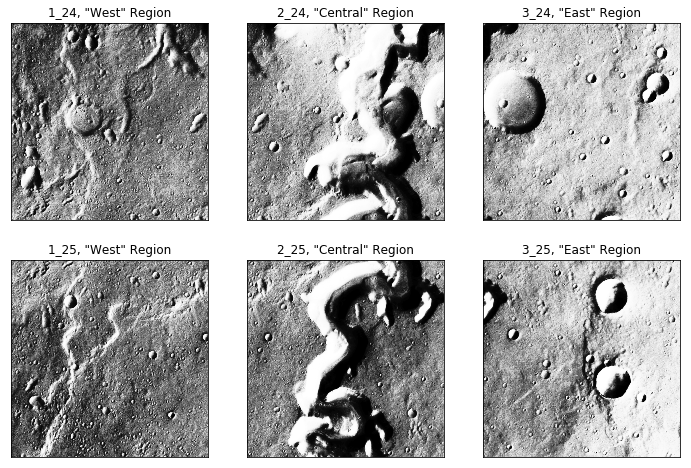

In [2]:
plot_tiles(tiles, tile_names, regions)

Each tile is 1700x1700 pixels, and each pixel is 12.5 square meters of the Martian surface. There is some overlap between the tiles, but each tile covers about 450 square kilometers; the entire photographed region spans ~37 km N-S and ~56 km E-W.

## "Ground Truth" Labels
Along with the dataset comes a set of 3658 crater annotations hand-labeled by an analyst for Urbach in his 2009 paper. In all subsequent papers using this dataset, these annotations are considered ground truths; that is, they are all the true craters that a human can identify in this area.

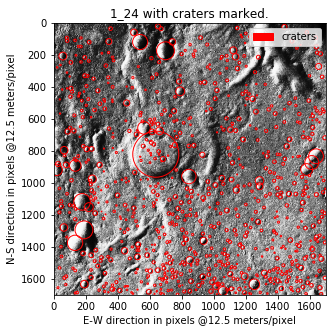

In [3]:
demo_tile = '1_24'
img = tiles[demo_tile]
scale = .25
craters_df = all_craters[all_craters.tile==demo_tile]
craters = {'craters': craters_df[['x', 'y', 'd']].values}
plot_craters(img, craters, title='Tile {} with craters marked.'.format(demo_tile), scale=scale)

## Urbach's Crater Proposals
Urbach's method returns a set of "crater proposals" with many false positives included; the idea is to apply additional screening to accept or reject proposals. These proposals are limited to craters 200m (16 pixels) in diameter at minimum and 5km (400 pixels) in diameter at maximum; note many of the craters annotated above are smaller than that minimum threshold.<br><br>
The proposals yielded by this method on these tiles was recorded and uploaded to GitHub by Cohen in 2016.

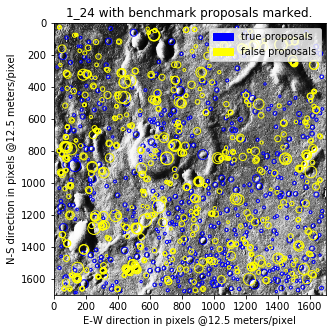

In [4]:
colors = ['blue', 'yellow']
title = '{} with benchmark proposals marked.'.format('1_24')
plot_craters(img, proposals, scale=scale, title=title, colors=colors)

## Techniques from Thinkful Course
This project will include a number of techniques from the Thinkful data science curriculum.

1. Implementing Urbach's crater detection method will require some algorithm coding in python.
2. The binary crater classifier will use convolutional neural nets implimented in Keras, as per my specialization in neural networks.
3. Post-hoc results analyses of error types and sensitivy ranges will make use of many analytic techniques used in the course.
4. Cluster analysis or other unsupervised techniques will aid in post-hoc analysis.

## Biggest Challenges
This project has a clear path, but the steps along that path that appear most challenging are:

1. Coding up Urbach's crater detection method. This uses a number of image analysis techniques not covered in the course. Fortunately, I have <a href='https://www.sciencedirect.com/science/article/pii/S0032063309000956'>this paper</a> to guide me through the process.
2. Building a python package and adding it to public repositories (I'd like to make it available via pip and anaconda, ideally). This is something I've never done before but I've always wanted to do, so I'm up for the learning experience and challenge.

These challenges are big but I understand the steps to address them. I see the scope of the project and I know I can deliver the bare minimum image-in, predictions-out user experience I envision in the alotted time.
<br>
## PyCDA: An Extensible Framework for Crater Detection
The product of this work will not be perfect; experts in this field of research have not achieved perfect results, so I cannot expect to do so myself. However, I would like to build a framework and pipeline that astronomers can use and developers/researchers can extend and improve. This will allow researchers on future projects to use PyCDA to impliment their novel ideas, astronomers to conduct their own surveys of planetary surfaces, and any other amount of cool science/hacking.